## Parameters
### Change the values in the next box.

In [1]:
annotation_image_path = "/home/tomoyuki/tmp/allen_atlas/annotation_50.nii"
cell_table_path = "/home/tomoyuki/tmp/kubota_data/cells_formatted_transformed.csv"
atlas_mm_per_voxel = 0.05

## Install libraries

First, install additional libraries that are not avaiable on Colaboratory by default.

In [2]:
requirements =[
    "allensdk",
    "nibabel"
]

for x in requirements:
    !pip install $x

### Import library

In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import ndimage as ndi
import nibabel as nb
import os
from allensdk.core.reference_space_cache import ReferenceSpaceCache

### Define functions

In [4]:
def load_nifti(src: str):
    stack = nb.load(src).get_fdata()
    stack = np.swapaxes(stack, 0, 2)
    stack = np.squeeze(stack)
    return stack

def query_region_id(ann, coords_in_um, atlas_mm_per_pixel):
    regions = ndi.map_coordinates(ann, coords_in_um/atlas_mm_per_pixel, order=0, mode="constant", cval=0)
    return regions

### Load ABA's annotation image

In [20]:
ann = load_nifti(annotation_image_path)

### Load cell table after coordinate transformation

In [21]:
cells = pd.read_csv(cell_table_path)

### Find region ID for each cell

In [22]:
cells["Region_id"] = query_region_id(ann, np.array([cells["Z"], cells["Y"], cells["X"]]), atlas_mm_per_pixel=atlas_mm_per_voxel)
display(cells)

,X,Y,Z,volume,intensity,Region_id
0,7.10685,8.441000,0.231499,39210.40,750.814,805.0
1,8.34579,8.910740,0.529426,12168.70,680.111,0.0
2,3.73238,8.143200,0.135689,4326.66,709.438,0.0
3,3.60364,8.122370,0.165509,25419.10,620.383,0.0
4,4.18478,8.051170,0.167567,65440.70,656.012,0.0
...,...,...,...,...,...,...
4990,7.17955,1.111310,5.845030,10816.70,1346.120,0.0
4991,7.01729,2.866420,6.172730,16225.00,946.483,0.0
4992,8.04655,4.588760,7.149260,6219.57,964.565,754.0
4993,6.63935,0.690923,5.857000,3515.41,842.000,1016.0


### Visualize cells and atlas

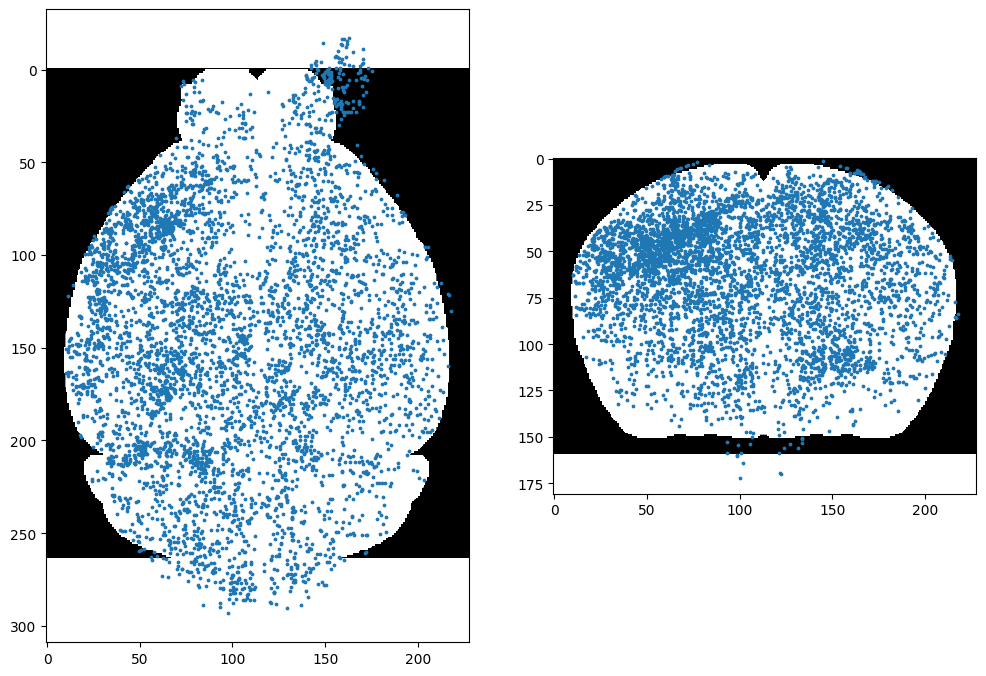

In [30]:
fig, axs = plt.subplots(1,2,figsize=(12,12))
axs[0].imshow(ann.max(axis=0), vmin=0, vmax=1, cmap="gray")
axs[0].scatter(cells["X"]/atlas_mm_per_voxel, cells["Y"]/atlas_mm_per_voxel, s=3)
axs[1].imshow(ann.max(axis=1), vmin=0, vmax=1, cmap="gray")
axs[1].scatter(cells["X"]/atlas_mm_per_voxel, cells["Z"]/atlas_mm_per_voxel, s=3)
plt.show()

### Remove cells with ID=0

In [10]:
cells = cells[cells["Region_id"] != 0]

### Save result

In [11]:
cells.to_csv("cells_with_ID.csv", sep=',', header=list(cells), index=False)

### Count number of cells in each region

In [12]:
class SummaryTable:
    def __init__ (self):
        # initialize allen structure tree
        rspc = ReferenceSpaceCache(25, os.path.join('annotation', 'ccf_2017'), manifest="manifest.json")
        tree = rspc.get_structure_tree(structure_graph_id=1)
        self.tree = tree
    
    def _get_descendants(self, queryid):
        """Get all descendant nodes (direct child and grand childs...) of the specified node"""
        descendants = []
        for node in self.tree.get_name_map():
            if self.tree.structure_descends_from(node, queryid):
                descendants.append(node)
        return descendants
    
    def create_summary(self, csvpath: str, savename: str, enable_volume=False, enable_intensity=False):
        # load cell talbe (X, Y, Z, ABA ID and optinaly intensity)
        if not os.path.exists(csvpath):
            raise FileNotFoundError("Cannnot find 'cellcsv'!")
        cells = pd.read_csv(csvpath, sep=",", header=0)
        
        out = pd.DataFrame(columns=["id", "acronym", "node_name", "count", "volume", "intensity"])

        idlist = [k for k in self.tree.get_name_map()]
        for (i, node_id) in enumerate(idlist):
            node = self.tree.get_structures_by_id([node_id])[0]
            node_id = node["id"]
            node_acr = node['acronym']
            node_name = node['name']

            count, volume, intensity = 0, 0, 0
            descendants = self._get_descendants(node_id)
            for c in descendants:
                rows = cells[cells["Region_id"]==c]
                if len(rows) > 0:
                    count += len(rows)
                    if enable_volume: volume += rows["volume"].sum()
                    if enable_intensity: intensity += rows["intensity"].sum()
            out.loc[i] = [node_id, node_acr, node_name, count, volume, intensity]
        
        out.to_csv(savename, sep=',', header=list(out), index=False)
        print(f"Table was saved as {savename}")
        return out

In [13]:
st = SummaryTable()
res = st.create_summary("cells_with_ID.csv", "summary.csv", enable_volume=True, enable_intensity=True)
display(res)

Table was saved as summary.csv


,id,acronym,node_name,count,volume,intensity
0,997,root,root,4093,1.477863e+09,6594715.778
1,8,grey,Basic cell groups and regions,3707,1.397114e+09,6056422.399
2,567,CH,Cerebrum,2548,8.592501e+08,4136960.528
3,688,CTX,Cerebral cortex,2357,7.804429e+08,3781900.482
4,695,CTXpl,Cortical plate,2321,7.539124e+08,3701812.998
...,...,...,...,...,...,...
1322,49,ipf,intraparafloccular fissure,0,0.000000e+00,0.000
1323,57,pms,paramedian sulcus,0,0.000000e+00,0.000
1324,65,pfs,parafloccular sulcus,0,0.000000e+00,0.000
1325,624,IPF,Interpeduncular fossa,0,0.000000e+00,0.000


## Make plots 

## 1. Plot the number of cancer tissues in each brain area

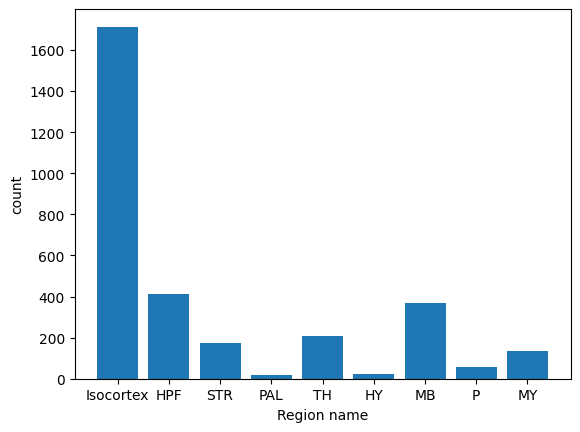

In [16]:
regions = ["Isocortex", "HPF", "STR", "PAL", "TH", "HY", "MB", "P", "MY"]
data = res[res["acronym"].isin(regions)].copy()

fig, ax = plt.subplots()
ax.bar(np.arange(data.shape[0]), data["count"])
ax.set_xticks(np.arange(data.shape[0]))
ax.set_xticklabels(data["acronym"].tolist())
ax.set_ylabel("count")
ax.set_xlabel("Region name")
plt.show()

## 2. Plot the total volume of cancer tissues in each brain area

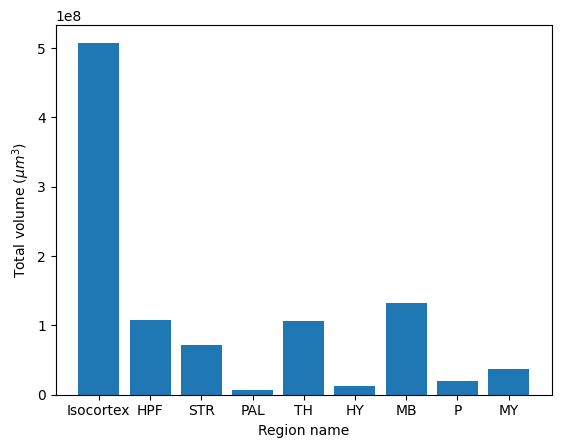

In [14]:
regions = ["Isocortex", "HPF", "STR", "PAL", "TH", "HY", "MB", "P", "MY"]
data = res[res["acronym"].isin(regions)].copy()

fig, ax = plt.subplots()
ax.bar(np.arange(data.shape[0]), data["volume"])
ax.set_xticks(np.arange(data.shape[0]))
ax.set_xticklabels(data["acronym"].tolist())
ax.set_ylabel("Total volume $(\mu m^3)$")
ax.set_xlabel("Region name")
plt.show()

## Normalize above plot by the total volume of each brain region

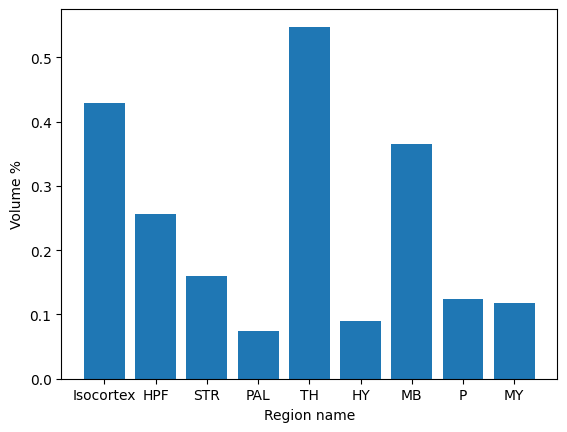

In [17]:
# volume of each brain region
rspc = ReferenceSpaceCache(25, os.path.join('annotation', 'ccf_2017'), manifest="manifest.json")
tree = rspc.get_structure_tree(structure_graph_id=1)

def _get_descendants(queryid):
        """Get all descendant nodes (direct child and grand childs...) of the specified node"""
        descendants = []
        for node in tree.get_name_map():
            if tree.structure_descends_from(node, queryid):
                descendants.append(node)
        return descendants

def calculate_region_volume(ann, region):
    node = tree.get_structures_by_acronym([region])[0]
    descendants = _get_descendants(node["id"])
    mask = np.isin(ann, descendants)
    volume = mask.sum() * 50**3
    return volume

regions = ["Isocortex", "HPF", "STR", "PAL", "TH", "HY", "MB", "P", "MY"]
data = res[res["acronym"].isin(regions)].copy()

vols = []
for r in regions:
    vols.append(calculate_region_volume(ann, r))
vols = np.array(vols)

data["normalized"] = 100 * data["volume"] / vols
    
fig, ax = plt.subplots()
ax.bar(np.arange(data.shape[0]), data["normalized"])
ax.set_xticks(np.arange(data.shape[0]))
ax.set_xticklabels(data["acronym"].tolist())
ax.set_ylabel("Volume %")
ax.set_xlabel("Region name")
plt.show()